# Using NLP to Predict Starbucks Reviews

https://www.kaggle.com/datasets/harshalhonde/starbucks-reviews-dataset

The goal of this project is to determine if Starbucks reviews are positive or negative based on NLP. I utilized BERT, RoBERTa and GPT to see if the ranking of reviews at Starbucks could be determined. A dataset from actual Starbucks reviews on Kaggle was utilized

In [107]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf
import keras_core as keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import TFBertModel
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
import kerastuner as kt
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, Dropout, Dense, Layer,Flatten, Bidirectional, LSTM
from tensorflow.keras.models import Model
import optuna
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import TFBertForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from transformers import RobertaTokenizer
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from transformers import TFGPT2Model, GPT2Tokenizer
from transformers import TFRobertaModel
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

## Data Cleaning and EDA

In [108]:
reviews= pd.read_csv('reviews_data.csv')

In [109]:
reviews.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [110]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


In [111]:
#So we have a lot of data so I am going to drop unneeded columns then sample from training data
reviewsClean = reviews[['Review', 'Rating']]


In [112]:
reviewsClean.head()

,Review,Rating
0,Amber and LaDonna at the Starbucks on Southwes...,5.0
1,** at the Starbucks by the fire station on 436...,5.0
2,I just wanted to go out of my way to recognize...,5.0
3,Me and my friend were at Starbucks and my card...,5.0
4,I’m on this kick of drinking 5 cups of warm wa...,5.0


In [113]:
reviewsClean['Review'] = reviewsClean['Review'].str.replace('\n', '', regex=True)

/var/folders/qg/s3zds0bx7dn468711v1v0hnw0000gn/T/ipykernel_14945/2884851264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviewsClean['Review'] = reviewsClean['Review'].str.replace('\n', '', regex=True)


In [114]:
reviewsClean['Review'] = reviewsClean['Review'].str.replace('*', '')
reviewsClean['Review'] = reviewsClean['Review'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
reviewsClean.head()

/var/folders/qg/s3zds0bx7dn468711v1v0hnw0000gn/T/ipykernel_14945/2982599500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviewsClean['Review'] = reviewsClean['Review'].str.replace('*', '')
/var/folders/qg/s3zds0bx7dn468711v1v0hnw0000gn/T/ipykernel_14945/2982599500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviewsClean['Review'] = reviewsClean['Review'].str.lower().str.translate(str.maketrans('', '', string.punctuation))


,Review,Rating
0,amber and ladonna at the starbucks on southwes...,5.0
1,at the starbucks by the fire station on 436 i...,5.0
2,i just wanted to go out of my way to recognize...,5.0
3,me and my friend were at starbucks and my card...,5.0
4,i’m on this kick of drinking 5 cups of warm wa...,5.0


In [115]:
reviewsClean = reviewsClean.dropna(subset=['Rating'])
reviewsClean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 705 entries, 0 to 749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  705 non-null    object 
 1   Rating  705 non-null    float64
dtypes: float64(1), object(1)
memory usage: 16.5+ KB


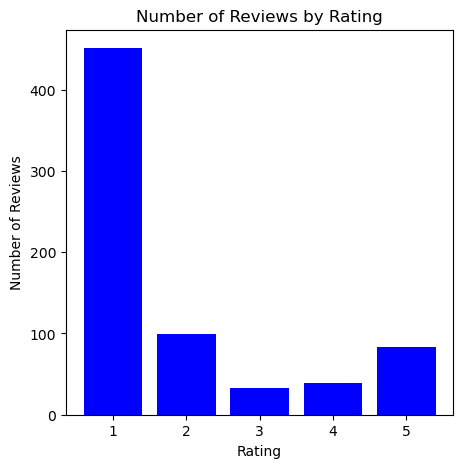

In [116]:
ratingCounts = reviewsClean['Rating'].value_counts().sort_index()

plt.figure(figsize=(5,5))
plt.bar(ratingCounts.index, ratingCounts.values, color='blue')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Rating')
plt.xticks(ratingCounts.index)
plt.show()

In [117]:
ratingCounts

Rating
1.0    451
2.0     99
3.0     33
4.0     39
5.0     83
Name: count, dtype: int64

Most reviews are 1 star

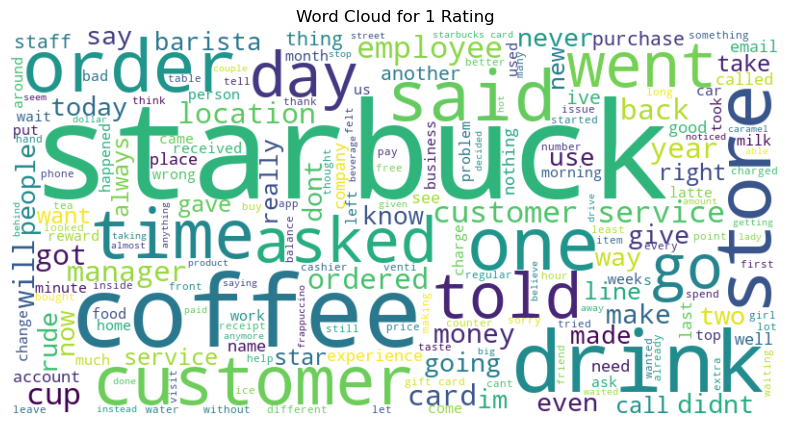

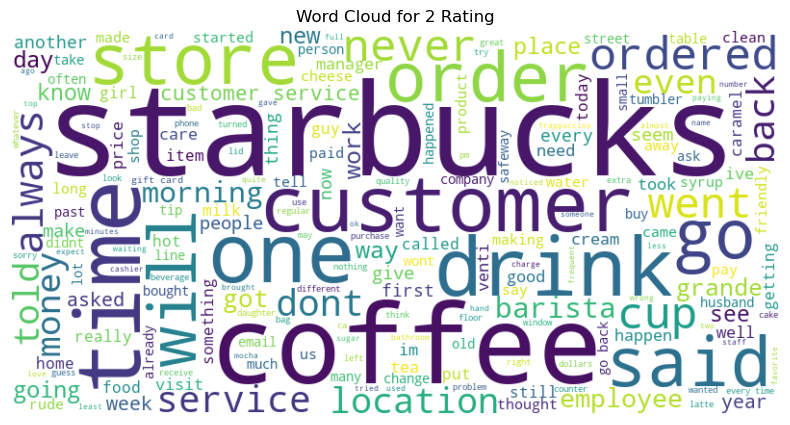

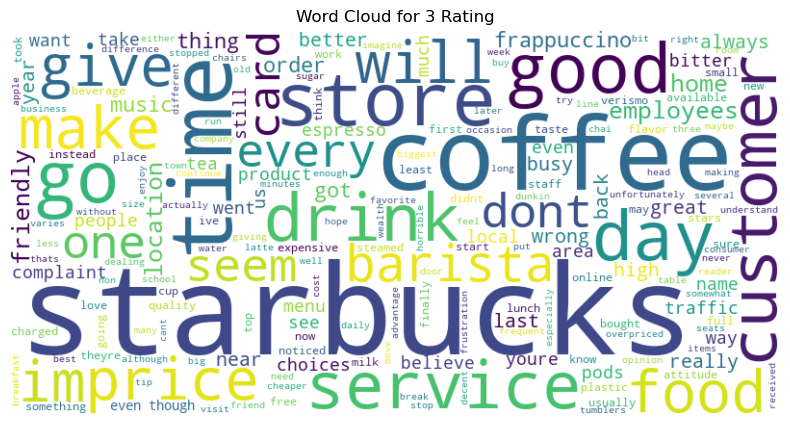

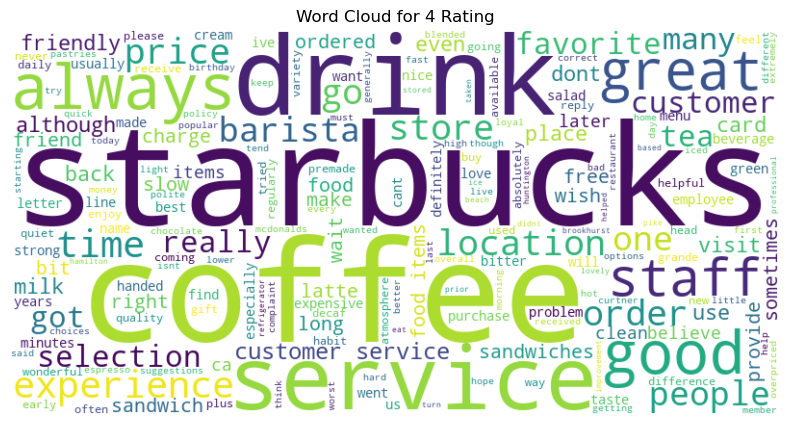

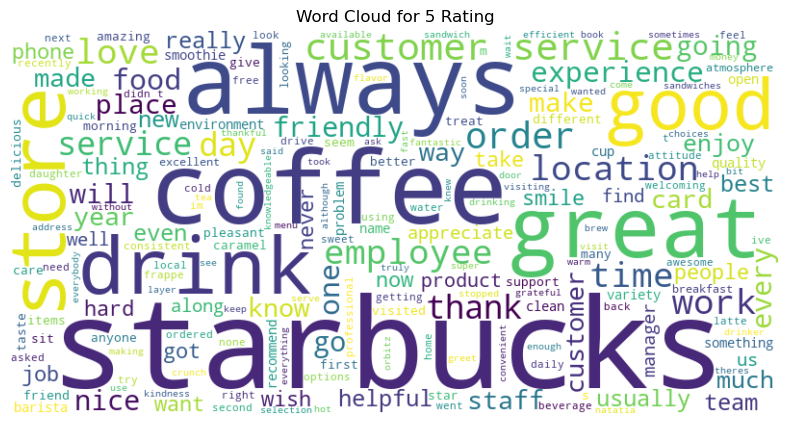

In [118]:
def createWordClouds(df, rating):
    text = " ".join(review for review in df[df['Rating'] == rating]['Review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {rating} Rating')
    plt.show()

for rating in [1,2,3,4,5]:
    createWordClouds(reviewsClean, rating)

In [119]:
def convert(rating):
    if 3 <= rating <= 5:
        return 1
    elif 1 <= rating <= 2:
        return 0
    else:
        return rating 
    
reviewsClean['Rating'] = reviewsClean['Rating'].apply(convert)

In [15]:
reviewsClean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 705 entries, 0 to 749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  705 non-null    object
 1   Rating  705 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 16.5+ KB


In [16]:
reviewsClean.info()

,Rating
count,705.000000
mean,0.219858
std,0.414444
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [106]:
#I'm classifying reviews as positive or negative because there isn't much positive data

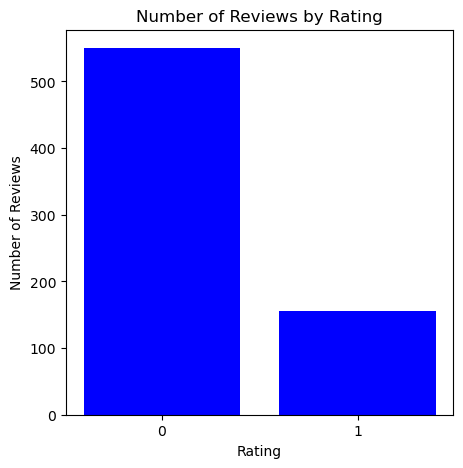

In [120]:
ratingCounts = reviewsClean['Rating'].value_counts().sort_index()

plt.figure(figsize=(5,5))
plt.bar(ratingCounts.index, ratingCounts.values, color='blue')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Rating')
plt.xticks(ratingCounts.index)
plt.show()

## First Model - BERT
I am going use, there are a lot of repeating words I think BERT will be suitable because it can understand words based on context

In [17]:
#Split data into training and validation
X = reviewsClean['Review']
y = reviewsClean['Rating']

Xtrain, Xval, ytrain, yval = train_test_split(X,y,test_size=0.2, random_state=42)

In [18]:
ytrain.value_counts()

Rating
0    447
1    117
Name: count, dtype: int64

In [19]:
yval.value_counts()

Rating
0    103
1     38
Name: count, dtype: int64

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize(text, tokenizer, maxLength = 50):
    return tokenizer(
        text.tolist(),
        max_length=maxLength,
        truncation=True,
        padding=True,
        add_special_tokens=True,
        return_tensors='tf')

In [41]:
enXtrain = tokenize(Xtrain, tokenizer)
enXval = tokenize(Xval, tokenizer)

In [42]:
bertModel = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = Input(shape=(50,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(50,), dtype=tf.int32, name='attention_mask')

class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.pooler_output

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [43]:
bertOutput = BertLayer()([input_ids, attention_mask])
pooledOutput = Flatten()(bertOutput)
#pooledOutput = bertOutput[1]
dropout = tf.keras.layers.Dropout(0.3)(pooledOutput)
output = tf.keras.layers.Dense(1,activation='sigmoid')(dropout)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [44]:
firstModel = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
firstModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [45]:
history = firstModel.fit(
    [enXtrain['input_ids'], enXtrain['attention_mask']],
    ytrain,
    validation_data=([enXval['input_ids'], enXval['attention_mask']], yval),
    epochs=3,
    batch_size=16
)

Epoch 1/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 745ms/step - accuracy: 0.2765 - loss: 1.0327 - val_accuracy: 0.2766 - val_loss: 0.9214
Epoch 2/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 810ms/step - accuracy: 0.2575 - loss: 0.9703 - val_accuracy: 0.2766 - val_loss: 0.8383
Epoch 3/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 782ms/step - accuracy: 0.3029 - loss: 0.8885 - val_accuracy: 0.2695 - val_loss: 0.7730


In [46]:
ypredVal = (firstModel.predict([enXval['input_ids'], enXval['attention_mask']]) > 0.5).astype("int32")

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


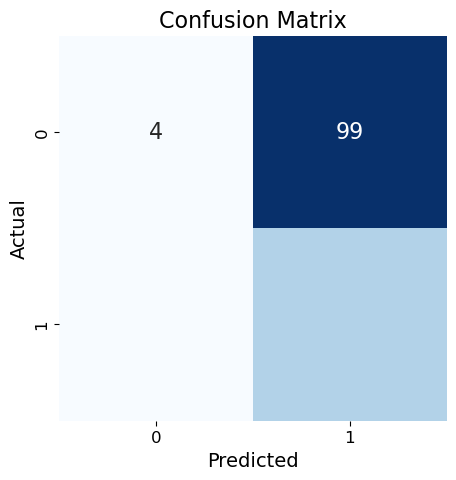

array([[ 4, 99],
       [ 4, 34]])

In [47]:
cm = confusion_matrix(yval, ypredVal)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm

### Hyperparameter Tuning for BERT Model

In [51]:
def build_model(hp):
    input_ids = Input(shape=(50,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(50,), dtype=tf.int32, name='attention_mask')

    bert_output = BertLayer()([input_ids, attention_mask])

    flattened_output = Flatten()(bert_output)

    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    dropout = Dropout(dropout_rate)(flattened_output)

    dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    output = Dense(dense_units, activation='relu')(dropout)

    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-5, 3e-5, 5e-5])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [52]:
tuner = kt.RandomSearch(build_model,
                     objective='val_accuracy',
                     executions_per_trial=1,
                     directory='tuning',
                     project_name='bert_hyperparameter_tuning',
                     max_trials=5)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search([enXtrain['input_ids'], enXtrain['attention_mask']],ytrain,
             validation_split=0.2,
             callbacks=[early_stopping],
             batch_size=32)

bestHPs=tuner.get_best_hyperparameters(num_trials=1)[0]
finalBertModel = tuner.hypermodel.build(bestHPs)

Trial 5 Complete [00h 00m 31s]
val_accuracy: 0.18584071099758148

Best val_accuracy So Far: 0.8141592741012573
Total elapsed time: 00h 02m 01s


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [53]:
bestHPsDict = bestHPs.values
bestHPsDf = pd.DataFrame([bestHPsDict])
#bestHPsDf.to_csv('bestHPs_BERT1.csv', index=False)

In [54]:
history = finalBertModel.fit(
    [enXtrain['input_ids'], enXtrain['attention_mask']],
    ytrain,
    validation_data=([enXval['input_ids'], enXval['attention_mask']], yval),
    epochs=3,
    batch_size=16
)

Epoch 1/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 824ms/step - accuracy: 0.5293 - loss: 0.6897 - val_accuracy: 0.7305 - val_loss: 0.6498
Epoch 2/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 726ms/step - accuracy: 0.7644 - loss: 0.5895 - val_accuracy: 0.7305 - val_loss: 0.6131
Epoch 3/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 687ms/step - accuracy: 0.7869 - loss: 0.5343 - val_accuracy: 0.7305 - val_loss: 0.5893


4/5 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x293f03c40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


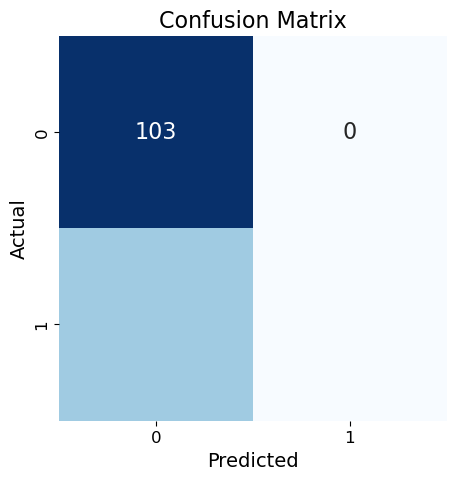

array([[103,   0],
       [ 38,   0]])

In [55]:
ypredVal2 = (finalBertModel.predict([enXval['input_ids'], enXval['attention_mask']]) > 0.5).astype("int32")
cm2 = confusion_matrix(yval, ypredVal2)
plt.figure(figsize=(5,5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm2

#### Next Iteration of BERT Model
First model conditions were unsatisfactory trying using another model, this uses a learning rate scheduler

In [59]:
learningRateScheduler = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [60]:
SecondModel = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
SecondModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learningRateScheduler), loss='mean_squared_error', metrics=['mae'])


In [61]:
history = SecondModel.fit(
    [enXtrain['input_ids'], enXtrain['attention_mask']],
    ytrain,
    validation_data=([enXval['input_ids'], enXval['attention_mask']], yval),
    epochs=3,
    batch_size=16
)

Epoch 1/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - loss: 0.3027 - mae: 0.5336 - val_loss: 0.2745 - val_mae: 0.5219
Epoch 2/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 500ms/step - loss: 0.2750 - mae: 0.5105 - val_loss: 0.2614 - val_mae: 0.5096
Epoch 3/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 588ms/step - loss: 0.2652 - mae: 0.4999 - val_loss: 0.2503 - val_mae: 0.4978


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


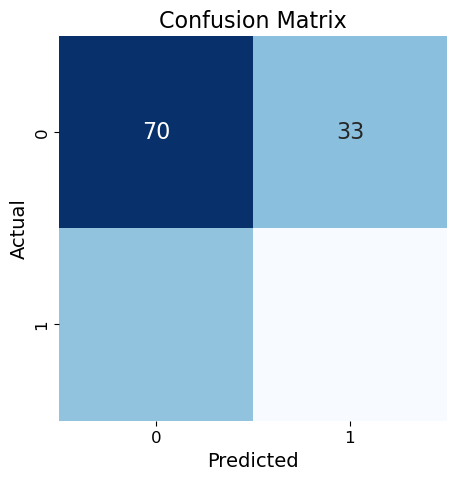

array([[70, 33],
       [32,  6]])

In [62]:
ypredVal2Bert = (SecondModel.predict([enXval['input_ids'], enXval['attention_mask']]) > 0.5).astype("int32")
cm2Bert = confusion_matrix(yval, ypredVal2Bert)
plt.figure(figsize=(5,5))
sns.heatmap(cm2Bert, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm2Bert

#### Hyperparameter Tuning

In [80]:
def build_model(hp):
    input_ids = Input(shape=(50,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(50,), dtype=tf.int32, name='attention_mask')

    bert_output = BertLayer()([input_ids, attention_mask])

    flattened_output = Flatten()(bert_output)

    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    dropout = Dropout(dropout_rate)(flattened_output)

    dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    output = Dense(dense_units, activation='relu')(dropout)

    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-5, 3e-5, 5e-5])),loss='mean_squared_error', metrics=[keras.metrics.MeanAbsoluteError()])

    return model

In [81]:
tuner = kt.RandomSearch(build_model,
                     objective=kt.Objective("val_mean_absolute_error", direction="min"),
                     executions_per_trial=1,
                     directory='tuning5',
                     project_name='bert_hyperparameter_tuning5',
                     max_trials=5 )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search([enXtrain['input_ids'], enXtrain['attention_mask']],ytrain,
             validation_split=0.2,
             callbacks=[early_stopping],
             batch_size=32)

bestHPsBert2=tuner.get_best_hyperparameters(num_trials=1)[0]
finalBertModel2 = tuner.hypermodel.build(bestHPsBert2)

Trial 5 Complete [00h 00m 39s]
val_mean_absolute_error: 0.381769061088562

Best val_mean_absolute_error So Far: 0.3751811981201172
Total elapsed time: 00h 04m 11s


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [82]:
bestHPsDict2 = bestHPsBert2.values
bestHPsDf2 = pd.DataFrame([bestHPsDict2])
bestHPsDf2.to_csv('bestHPs_BERT2.csv', index=False)

In [83]:
history = finalBertModel2.fit(
    [enXtrain['input_ids'], enXtrain['attention_mask']],
    ytrain,
    validation_data=([enXval['input_ids'], enXval['attention_mask']], yval),
    epochs=3,
    batch_size=16
)

Epoch 1/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 865ms/step - loss: 0.4095 - mean_absolute_error: 0.6412 - val_loss: 0.2027 - val_mean_absolute_error: 0.5169
Epoch 2/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 801ms/step - loss: 0.1863 - mean_absolute_error: 0.4824 - val_loss: 0.2176 - val_mean_absolute_error: 0.4295
Epoch 3/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 771ms/step - loss: 0.1652 - mean_absolute_error: 0.4137 - val_loss: 0.2146 - val_mean_absolute_error: 0.3927


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 750ms/step


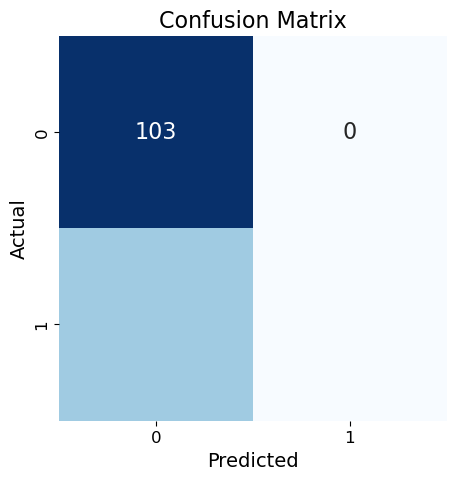

array([[103,   0],
       [ 38,   0]])

In [84]:
ypredVal2Bert = (finalBertModel2.predict([enXval['input_ids'], enXval['attention_mask']]) > 0.5).astype("int32")
cm2Bert = confusion_matrix(yval, ypredVal2Bert)
plt.figure(figsize=(5,5))
sns.heatmap(cm2Bert, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm2Bert

## RoBERTa Model
Using this because it is a more complex model and perhaps it will yield better results than simply BERT

In [85]:
tokenizerRo = RobertaTokenizer.from_pretrained('roberta-base')

def tokenizeRo(text, tokenizerRo, maxLength = 50):
    return tokenizer(
        text.tolist(),
        max_length=maxLength,
        truncation=True,
        padding=True,
        add_special_tokens=True,
        return_tensors='tf'
    )

enXtrainRo = tokenizeRo(Xtrain, tokenizer)
enXvalRo = tokenizeRo(Xval, tokenizer)

In [86]:
robertaModel = TFRobertaModel.from_pretrained('roberta-base')
input_ids = Input(shape=(50,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(50,), dtype=tf.int32, name='attention_mask')

class RoBertaLayer(Layer):
    def __init__(self, **kwargs):
        super(RoBertaLayer, self).__init__(**kwargs)
        self.roberta = TFRobertaModel.from_pretrained('roberta-base')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.pooler_output

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [87]:
robertaOutput=RoBertaLayer()([input_ids, attention_mask])
pooledOutput = Flatten()(robertaOutput)
dropout = Dropout(0.3)(pooledOutput)
output = Dense(1, activation='sigmoid')(dropout)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [88]:
learningRateScheduler = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [89]:
robertaModel= tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
robertaModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learningRateScheduler), loss='mean_squared_error', metrics=['mae'])


In [90]:
history = robertaModel.fit(
    [enXtrainRo['input_ids'], enXtrainRo['attention_mask']],
    ytrain,
    validation_data=([enXvalRo['input_ids'], enXvalRo['attention_mask']], yval),
    epochs=3,
    batch_size=16
)

Epoch 1/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 480ms/step - loss: 0.2547 - mae: 0.5027 - val_loss: 0.2463 - val_mae: 0.4962
Epoch 2/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 496ms/step - loss: 0.2458 - mae: 0.4940 - val_loss: 0.2421 - val_mae: 0.4918
Epoch 3/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 639ms/step - loss: 0.2417 - mae: 0.4896 - val_loss: 0.2381 - val_mae: 0.4874


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


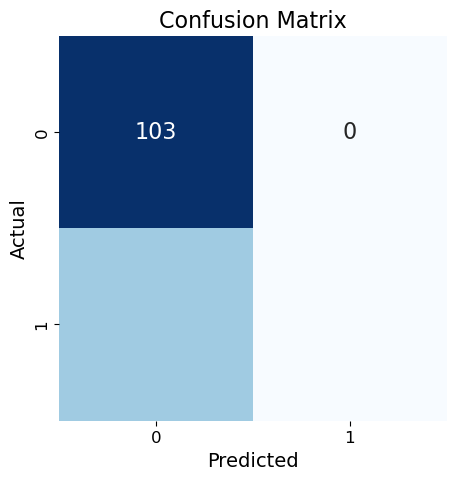

array([[103,   0],
       [ 38,   0]])

In [91]:
ypredValRo = (robertaModel.predict([enXvalRo['input_ids'], enXvalRo['attention_mask']]) > 0.5).astype("int32")
cm3 = confusion_matrix(yval, ypredValRo)
plt.figure(figsize=(5,5))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm3

### Hyperparameters for RoBERTa Model

In [92]:
robertaModel = TFRobertaModel.from_pretrained('roberta-base')
input_ids = Input(shape=(50,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(50,), dtype=tf.int32, name='attention_mask')

class RoBertaLayer(Layer):
    def __init__(self, **kwargs):
        super(RoBertaLayer, self).__init__(**kwargs)
        self.roberta = TFRobertaModel.from_pretrained('roberta-base')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.pooler_output
    
robertaOutput=RoBertaLayer()([input_ids, attention_mask])
pooledOutput = Flatten()(robertaOutput)
dropout = Dropout(0.3)(pooledOutput)
output = Dense(1, activation='sigmoid')(dropout)

learningRateScheduler = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [95]:
robertaModel2= tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
robertaModel2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learningRateScheduler), loss='binary_crossentropy', metrics=['accuracy'])


In [96]:
history = robertaModel2.fit(
    [enXtrainRo['input_ids'], enXtrainRo['attention_mask']],
    ytrain,
    validation_data=([enXvalRo['input_ids'], enXvalRo['attention_mask']], yval),
    epochs=3,
    batch_size=16
)

Epoch 1/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 536ms/step - accuracy: 0.7708 - loss: 0.6243 - val_accuracy: 0.7305 - val_loss: 0.6407
Epoch 2/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 564ms/step - accuracy: 0.7300 - loss: 0.6347 - val_accuracy: 0.7305 - val_loss: 0.6347
Epoch 3/3
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 675ms/step - accuracy: 0.7633 - loss: 0.6191 - val_accuracy: 0.7305 - val_loss: 0.6290


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


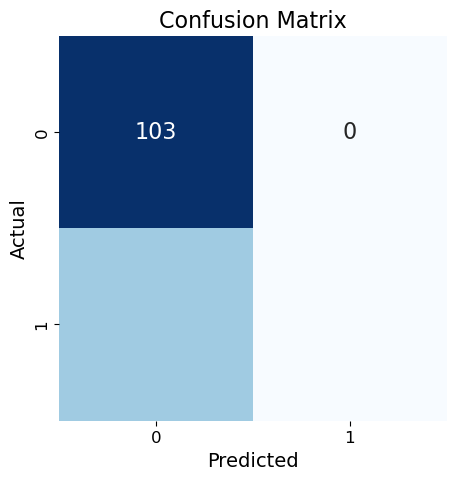

array([[103,   0],
       [ 38,   0]])

In [97]:
ypredVal4 = (robertaModel2.predict([enXvalRo['input_ids'], enXvalRo['attention_mask']]) > 0.5).astype("int32")
cm4 = confusion_matrix(yval, ypredVal4)
plt.figure(figsize=(5,5))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm4

## GPT Model

In [98]:
tokenizerGPT = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = TFGPT2Model.from_pretrained('gpt2')
def tokenizeGPT(text, tokenizerRo, maxLength = 50):
    return tokenizer(
        text.tolist(),
        max_length=maxLength,
        truncation=True,
        padding=True,
        add_special_tokens=True,
        return_tensors='tf'
    )

enXtrainGPT = tokenizeGPT(Xtrain, tokenizer)
enXvalGPT = tokenizeGPT(Xval, tokenizer)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [100]:
input_ids = Input(shape=(50,), dtype=tf.int32, name='input_ids')
                  
class GPT2Layer(Layer):
    def __init__(self, **kwargs):
        super(GPT2Layer, self).__init__(**kwargs)
        self.gpt2 = TFGPT2Model.from_pretrained('gpt2')

    def call(self, inputs):
        input_ids=inputs
        outputs=self.gpt2(input_ids)
        return outputs.last_hidden_state[:,-1]

In [101]:
gpt2Out= GPT2Layer()(input_ids)
pooled= Flatten()(gpt2Out)
dropout= Dropout(0.3)(pooled)
output= Dense(1, activation='linear')(dropout)

GPTmodel=Model(inputs=input_ids, outputs=output)
GPTmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='mean_squared_error', metrics=['mae'])

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [102]:
history=GPTmodel.fit(
    enXtrainGPT['input_ids'],
    ytrain,
    validation_data=(enXvalGPT['input_ids'], yval),
    epochs=3,
    batch_size=32
)

Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 518.1538 - mae: 20.4714 - val_loss: 411.3353 - val_mae: 19.2622
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 497.5727 - mae: 19.6282 - val_loss: 404.5494 - val_mae: 19.1038
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 480.0179 - mae: 19.0573 - val_loss: 397.9127 - val_mae: 18.9479


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


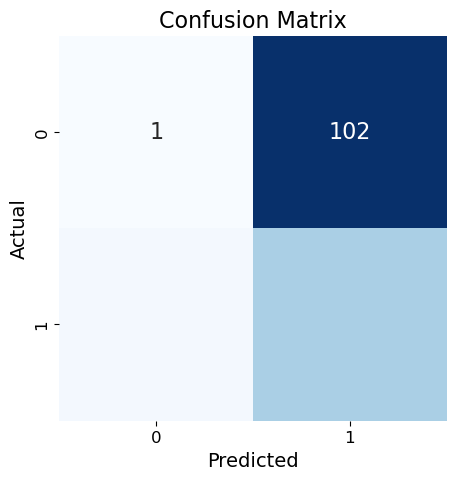

array([[  1, 102],
       [  3,  35]])

In [105]:
ypredVal5 = (GPTmodel.predict(enXvalGPT['input_ids']) > 0.5).astype("int32")
cm5 = confusion_matrix(yval, ypredVal5)
plt.figure(figsize=(5,5))
sns.heatmap(cm5, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

cm5

Interesting result as GPT is primarily used for generating texts

In future, I would continue tweaking GPT to try and get that model to perform better. It was the only along with the BERT model that was able to correctly predict if a review was positive. BERT however, was inconsistent. However, main problem with the models was a lack of overall data and if there was more data perhaps I would be able to predict positive reviews better. As it stands very little positive reviews lead to poor data outcomes. Maybe weight normalization could have also helped with this.